#### Introduction
This is my first NLP project. I am going to process the Fake Job Dataset and create ML models to predict if they are fraudulent or not.

##### About the dataset

[Real or Fake] : Fake Job Description Prediction
This dataset contains 18K job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs. The dataset can be used to create classification models which can learn the job descriptions which are fraudulent.

Kaggle Dataset Link: https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction



#### Import libraries and load the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import spacy
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import joblib

In [2]:
df = pd.read_csv("fake_job_postings.csv")

#### Exploratory Data Analysis

In [3]:

df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
df.drop(columns="job_id", inplace=True)

In [5]:
df.fraudulent.value_counts()

fraudulent
0    17014
1      866
Name: count, dtype: int64

We have to deal with the unbalanced data problem

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15184 non-null  object
 7   benefits             10668 non-null  object
 8   telecommuting        17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  frau

C:\Users\maria\AppData\Local\Temp\ipykernel_13076\3571073234.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])


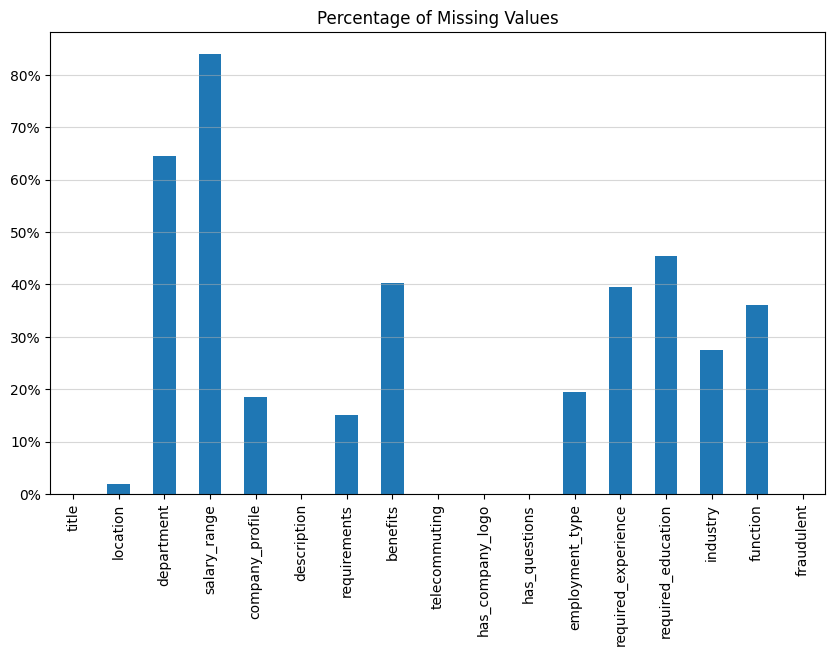

In [7]:
missing_percentage = round(df.isnull().sum() * 100 / len(df), 2)

plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar')
plt.title('Percentage of Missing Values')
plt.xticks(rotation=90)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])  
plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.show()

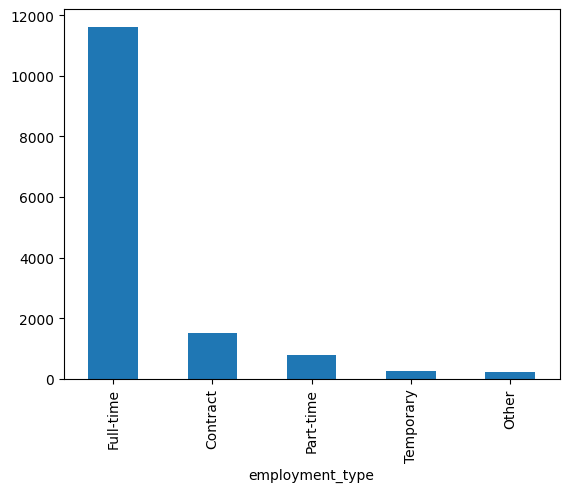

In [8]:
df.employment_type.value_counts().plot(kind="bar");

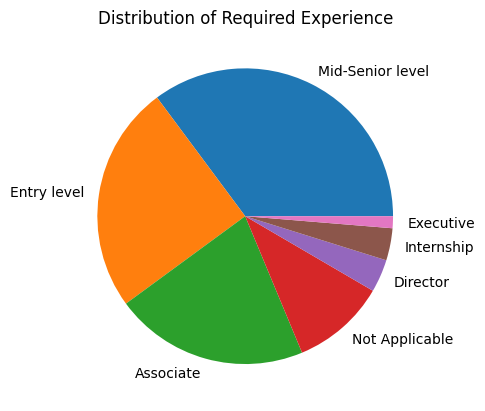

In [9]:
plt.title('Distribution of Required Experience')
df.required_experience.value_counts().plot(kind="pie");
plt.ylabel('')
plt.show();

#### Feature Engineering

In [10]:
df.columns

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [11]:
columns = ["salary_range", "department", "requirements", "company_profile", "benefits", "employment_type", "required_experience", "required_education", "industry", "function"]
for column in columns:
    df[f"{column}_is_empty"] = (df[column].isnull()).astype(int)

In [12]:
def concatenate_columns(row):
    text = ""
    for value in row.values:
        if isinstance(value, str):
            text += value + " "
    return text.strip()

df["text"] = df.apply(concatenate_columns, axis=1)

In [13]:
nlp = spacy.load("en_core_web_sm")
def preprocess(text):
    doc = nlp(text)
    filtered_words = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct)]
    return " ".join(filtered_words)

In [14]:
#df["text"] = df["text"].apply(preprocess)
#df.to_csv("processed_data.csv")

In [15]:
df = pd.read_csv("processed_data.csv")

#### Data Augmentation 

In [16]:
fraudulent_df = df[df["fraudulent"] == 1].sample(17014, replace=True, random_state=1, axis=0)
not_fraudulent_df = df[df["fraudulent"] == 0]

df = pd.concat([not_fraudulent_df, fraudulent_df], axis=0)
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
df.fraudulent.value_counts()

fraudulent
1    17014
0    17014
Name: count, dtype: int64

#### RandomForestClassifier Model (only numerical data)

In [17]:
numerical_df = df.select_dtypes(include=["float64", "int64", "int32"])

X_train, X_test, y_train, y_test = train_test_split(
    numerical_df.drop(columns=["fraudulent"]), 
    numerical_df.fraudulent, 
    test_size=0.2,
    random_state=1,
    stratify=df.fraudulent
)

In [18]:
model = RandomForestClassifier()

model.fit(X_train, y_train)

# Predict on the test set
predicted = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      3403
           1       0.84      0.89      0.86      3403

    accuracy                           0.86      6806
   macro avg       0.86      0.86      0.86      6806
weighted avg       0.86      0.86      0.86      6806



#### MultinomialNB and RandomForestClassifier Models using Bag of Words (CountVectorizer) for text vectorization (only text data)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    df.text, 
    df.fraudulent, 
    test_size=0.2,
    random_state=1,
    stratify=df.fraudulent
)

In [20]:
model = make_pipeline(CountVectorizer(), MultinomialNB())
model.fit(X_train, y_train)

predicted = model.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3403
           1       0.96      0.98      0.97      3403

    accuracy                           0.97      6806
   macro avg       0.97      0.97      0.97      6806
weighted avg       0.97      0.97      0.97      6806



In [21]:
model = make_pipeline(CountVectorizer(), RandomForestClassifier())

model.fit(X_train, y_train)

# Predict on the test set
predicted = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3403
           1       1.00      1.00      1.00      3403

    accuracy                           1.00      6806
   macro avg       1.00      1.00      1.00      6806
weighted avg       1.00      1.00      1.00      6806



I didn´t find any mistake in my code. I think I got these result because the data was artificially created or something like that.

In [22]:
joblib.dump(model, "model.pkl")

['model.pkl']